In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from sklearn.neighbors.kd_tree import KDTree
import numpy as np
import scipy.stats as st
from shapely.geometry import box
from descartes import PolygonPatch

<IPython.core.display.Javascript object>


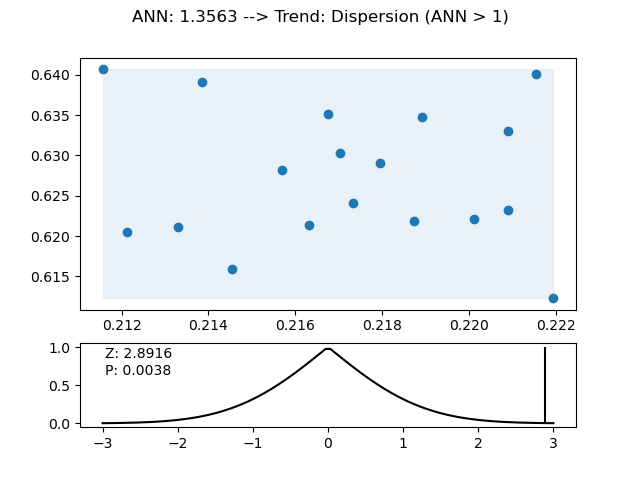

In [5]:

fig, (ax, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]})
fig.suptitle("Click on canvas to add points")

pts = []
sc = None

def calc_ann(pts):


    if len(pts) < 2:
        fig.suptitle("Click on canvas to add points")
        return

    pts = np.array([p for p in pts if p[0] is not None and p[1] is not None])

    mins = np.min(pts, axis=0)
    maxs = np.max(pts, axis=0)

    N = len(pts)
    A = (maxs[0] - mins[0]) * (maxs[1] - mins[1])

    # Calculate expected distance
    D_e = 0.5 / np.sqrt(N / A)

    # Calculate observed distance
    tree = KDTree(pts, leaf_size=2)
    dist, _ = tree.query(pts, k=2)
    D_o = np.mean(dist, axis=0)[1]

    ANN = D_o / D_e

    s = 0.26136 / np.sqrt(N**2 / A)
    z_score = (D_o - D_e) / s
    p_value = st.norm.sf(abs(z_score)) * 2

    cluster_trend = "Clustering (ANN < 1)"
    if ANN > 1:
        cluster_trend = "Dispersion (ANN > 1)"

    fig.suptitle("ANN: {} --> Trend: {}".format(round(ANN, 4),
                                                cluster_trend))
    
    # Plot Area
    bb = box(mins[0], mins[1], maxs[0], maxs[1])
    patch = PolygonPatch(bb, ec='#6699cc', alpha=0.1, zorder=1)
    ax.add_patch(patch)
    
    plot_cdf(z_score, p_value)

def plot_cdf(z_score, p_value):
    
    ax1.cla()

    ax1.text(0.05,
             0.95,
             "Z: {} \nP: {}".format(round(z_score, 4), round(p_value, 4)),
             horizontalalignment='left',
            verticalalignment='top',
             transform=ax1.transAxes)
    
    min_x = -3
    max_x = 3
    
    xs = np.linspace(min_x, max_x, num=100)
    ys = st.norm.sf(abs(xs)) * 2
    ax1.plot(xs, ys, color='k')
    
    z_score = min(max_x, z_score)
    z_score = max(min_x, z_score)
    
    ax1.vlines(z_score, 0, 1.0)

    


def onclick(event):
    pts.append((event.xdata, event.ydata))

    ax.cla()
    sc = ax.scatter([d[0] for d in pts],
                    [d[1] for d in pts])

    calc_ann(pts)

    plt.draw()

cid = fig.canvas.mpl_connect('button_press_event', onclick)

plt.show()